In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
import xgboost as xgb

In [4]:
# --- 1. Data Loading and Preparation ---

# Load the full dataset
try:
    df = pd.read_csv('forest_dataset.csv')
except FileNotFoundError:
    print("Error: 'forest_dataset.csv' not found. Please ensure the dataset is in the correct directory.")
    exit()

In [5]:
# Add column names
columns = [
    'Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
    'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
    'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
    'Horizontal_Distance_To_Fire_Points'
] + [f'Wilderness_Area_{i}' for i in range(1, 5)] + [f'Soil_Type_{i}' for i in range(1, 41)] + ['Cover_Type']
df.columns = columns

print(f"--- Full dataset loaded. Shape: {df.shape} ---")

--- Full dataset loaded. Shape: (10000, 55) ---


In [6]:
# --- 2. Using the Full Dataset for Training ---

X = df.drop('Cover_Type', axis=1)
y = df['Cover_Type']

In [7]:
# Train/test split using the full dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)


In [8]:
# Balance classes using SMOTE on the training data
print("--- Applying SMOTE to balance training data... ---")
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print(f"Shape of training data before SMOTE: {X_train.shape}")
print(f"Shape of training data after SMOTE: {X_train_res.shape}")

--- Applying SMOTE to balance training data... ---
Shape of training data before SMOTE: (8000, 54)
Shape of training data after SMOTE: (27307, 54)


In [9]:
# --- 3. Baseline Model Training (on Full Data) ---

# Train Decision Tree (as a baseline)
print("\n--- Training Baseline Decision Tree on full data... ---")
dt = DecisionTreeClassifier(max_depth=20, random_state=42)
dt.fit(X_train_res, y_train_res)
y_pred_dt = dt.predict(X_test)
acc_dt = accuracy_score(y_test, y_pred_dt)
print(f"Baseline Decision Tree Accuracy: {acc_dt:.4f}")


--- Training Baseline Decision Tree on full data... ---
Baseline Decision Tree Accuracy: 0.6980


In [10]:
# Train Random Forest (as a baseline)
print("\n--- Training Baseline Random Forest on full data... ---")
rf_base = RandomForestClassifier(n_estimators=50, max_depth=20, random_state=42, n_jobs=-1)
rf_base.fit(X_train_res, y_train_res)
y_pred_rf_base = rf_base.predict(X_test)
acc_rf_base = accuracy_score(y_test, y_pred_rf_base)
print(f"Baseline Random Forest Accuracy: {acc_rf_base:.4f}")


--- Training Baseline Random Forest on full data... ---
Baseline Random Forest Accuracy: 0.7770


In [11]:
# --- 4. IMPROVEMENT: Hyperparameter Tuning for Random Forest ---

print("\n--- Tuning Random Forest with RandomizedSearchCV... ---")
# Define the parameter distribution for Randomized Search
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [20, 30, 40, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}



--- Tuning Random Forest with RandomizedSearchCV... ---


In [12]:
# Define the parameter distribution for Randomized Search
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [20, 30, 40, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

In [13]:
# Set up RandomizedSearchCV
rf_random = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
    param_distributions=param_dist,
    n_iter=10,  # Number of parameter settings that are sampled
    cv=3,       # 3-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1
)

In [14]:
# Fit the random search model
rf_random.fit(X_train_res, y_train_res)
print(f"\nBest parameters found: {rf_random.best_params_}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits

Best parameters found: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 30, 'bootstrap': False}


In [15]:
# Predict with the best estimator
best_rf = rf_random.best_estimator_
y_pred_rf_tuned = best_rf.predict(X_test)
acc_rf_tuned = accuracy_score(y_test, y_pred_rf_tuned)
print(f"\nTuned Random Forest Accuracy: {acc_rf_tuned:.4f}")


Tuned Random Forest Accuracy: 0.7970


In [16]:
# --- 5. IMPROVEMENT: Using XGBoost Classifier ---

print("\n--- Training XGBoost Classifier... ---")
# XGBoost expects labels to start from 0
y_train_xgb = y_train_res - 1
y_test_xgb = y_test - 1


--- Training XGBoost Classifier... ---


In [17]:
# Initialize and train the XGBoost model
xgb_clf = xgb.XGBClassifier(objective='multi:softmax', num_class=7, random_state=42, n_jobs=-1)
xgb_clf.fit(X_train_res, y_train_xgb)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=-1, num_class=7, ...)

In [18]:
# Make predictions
y_pred_xgb = xgb_clf.predict(X_test)
acc_xgb = accuracy_score(y_test_xgb, y_pred_xgb)
print(f"XGBoost Accuracy: {acc_xgb:.4f}")

XGBoost Accuracy: 0.7880



--- Final Model Comparison ---


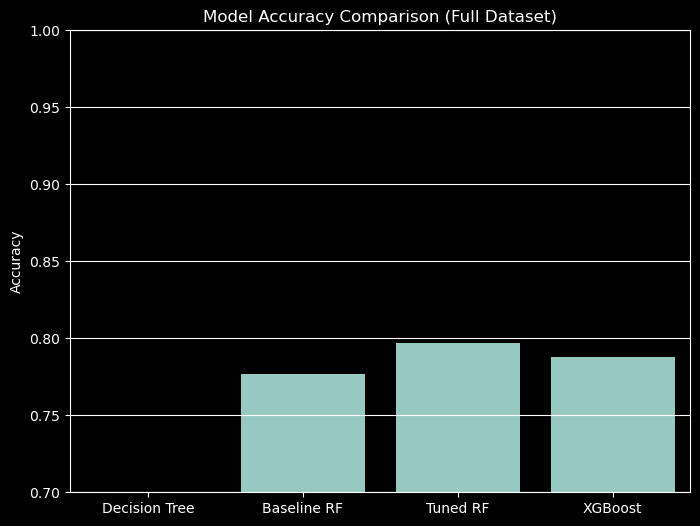

In [19]:
# --- 6. Final Evaluation and Comparison ---

print("\n--- Final Model Comparison ---")
models = ["Decision Tree", "Baseline RF", "Tuned RF", "XGBoost"]
accuracies = [acc_dt, acc_rf_base, acc_rf_tuned, acc_xgb]

plt.figure(figsize=(8, 6))
sns.barplot(x=models, y=accuracies)
plt.ylim(0.7, 1.0)
plt.title("Model Accuracy Comparison (Full Dataset)")
plt.ylabel("Accuracy")
plt.grid(axis='y')
plt.show()

In [20]:
# --- Detailed Report for the Best Model (Tuned RF) ---
print("\n--- Tuned Random Forest Classification Report ---\n")
print(classification_report(y_test, y_pred_rf_tuned))


--- Tuned Random Forest Classification Report ---

              precision    recall  f1-score   support

           1       0.80      0.79      0.79       738
           2       0.82      0.82      0.82       975
           3       0.73      0.87      0.79       118
           4       1.00      0.50      0.67        10
           5       0.52      0.39      0.45        33
           6       0.58      0.57      0.57        60
           7       0.86      0.85      0.85        66

    accuracy                           0.80      2000
   macro avg       0.76      0.68      0.71      2000
weighted avg       0.80      0.80      0.80      2000



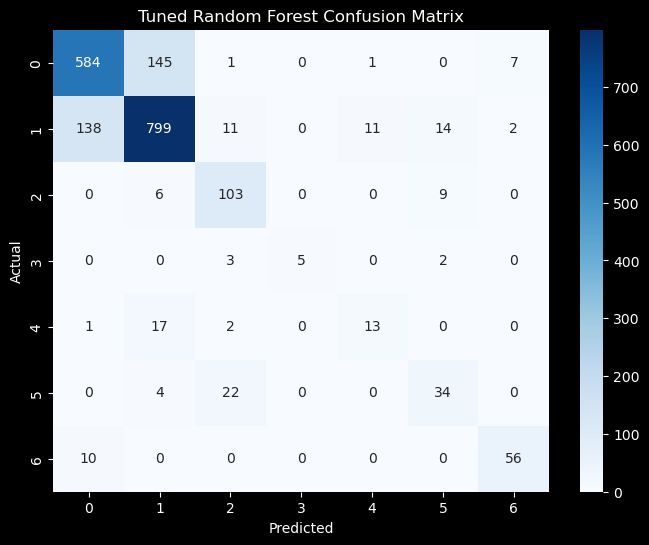

In [22]:
# Confusion Matrix for the Best Model
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_rf_tuned)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Tuned Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


--- Top 15 Feature Importances from Tuned Random Forest ---


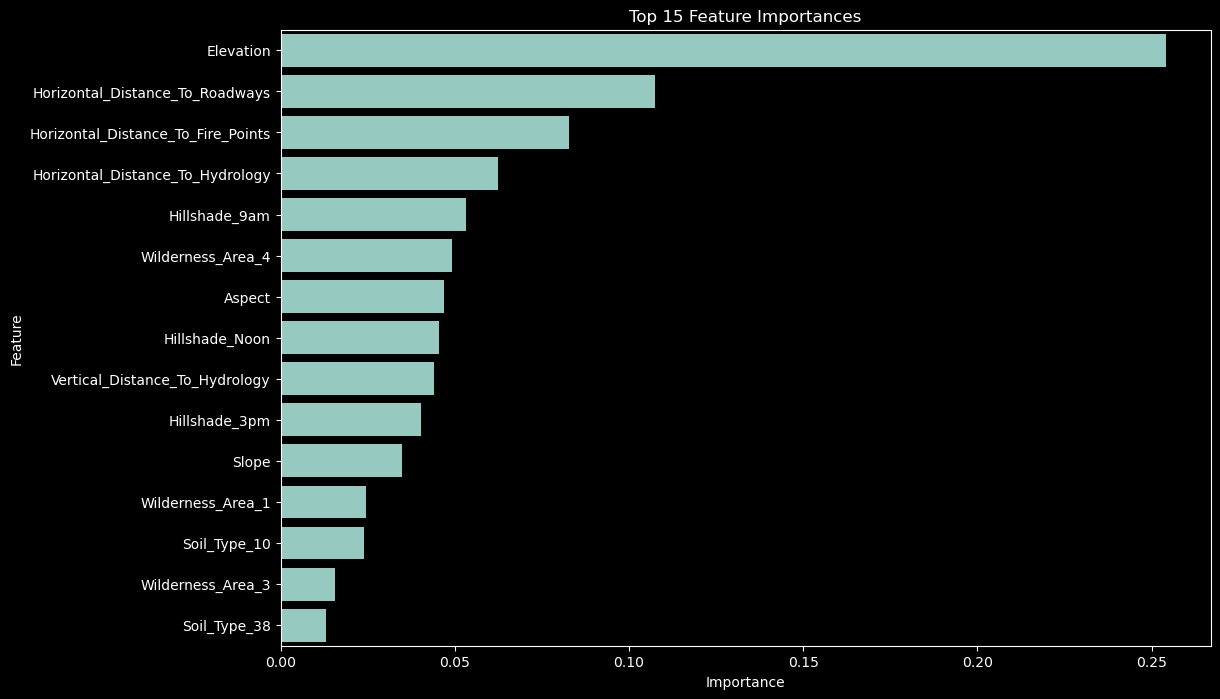

In [23]:
# --- Feature Importance Analysis ---
print("\n--- Top 15 Feature Importances from Tuned Random Forest ---")
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns

plt.figure(figsize=(12, 8))
sns.barplot(x=importances[indices[:15]], y=feature_names[indices[:15]])
plt.title('Top 15 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()